# Laboratorio 2: Demanda Eléctrica

> **Análisis de Series Temporales** - *Diplomatura en Ciencias de Datos, Aprendizaje Automático
y sus aplicaciones.*

> Gonzalo Zigarán

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Lectura de datos

In [3]:
data = pd.read_csv('demanda.csv')
data.tail()

,TIPO,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
39,1/4/2018,4.084.110,3.131.427,3.277.777,10.493.315
40,1/5/2018,4.276.830,3.101.854,3.286.778,10.665.462
41,1/6/2018,5.569.775,3.231.036,3.123.287,11.924.098
42,1/7/2018,6.167.114,3.326.186,3.112.541,12.605.842
43,1/8/2018,5.359.054,3.237.765,3.112.882,11.709.701


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 5 columns):
TIPO                           44 non-null object
Residencial                    44 non-null object
Comercial                      44 non-null object
Industrial/Comercial Grande    44 non-null object
TOTAL                          44 non-null object
dtypes: object(5)
memory usage: 1.8+ KB
None


### Indice en datetime

Convertimos las columnas que hacen referencia a la fecha del registro a un valor `datetime` e indexeamos el DataFrame por este valor.

In [5]:
data.index = pd.PeriodIndex((pd.to_datetime(data['TIPO'], dayfirst=True)), freq='M')
data = data.drop(columns=['TIPO'])
data.sample(5)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2017-04,3.754.330,2.900.824,3.138.604,9.793.759
2016-09,4.351.182,2.996.680,3.034.220,10.382.081
2017-01,5.681.817,3.670.275,3.172.774,12.524.866
2017-06,5.180.585,3.071.334,3.107.412,11.359.331
2018-07,6.167.114,3.326.186,3.112.541,12.605.842


### Columnas a enteros

Se observa que las columnas no están en el formato deseado, están como objeto y no como un valor numérico.

In [6]:
data['TOTAL'] = data['TOTAL'].apply(lambda x: int(x.replace('.', '')))
data['Residencial'] = data['Residencial'].apply(lambda x: int(x.replace('.', '')))
data['Comercial'] = data['Comercial'].apply(lambda x: int(x.replace('.', '')))
data['Industrial/Comercial Grande'] = data['Industrial/Comercial Grande'].apply(lambda x: int(x.replace('.', '')))
data.sample(5)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2016-07,5614535,3277709,3037401,11929645
2017-10,3979758,3041199,3206372,10227329
2015-12,5196472,3381377,3331586,11909436
2017-07,5460616,3170033,3165777,11796426
2015-05,4224673,2979187,3263774,10467634


## Visualización de las series

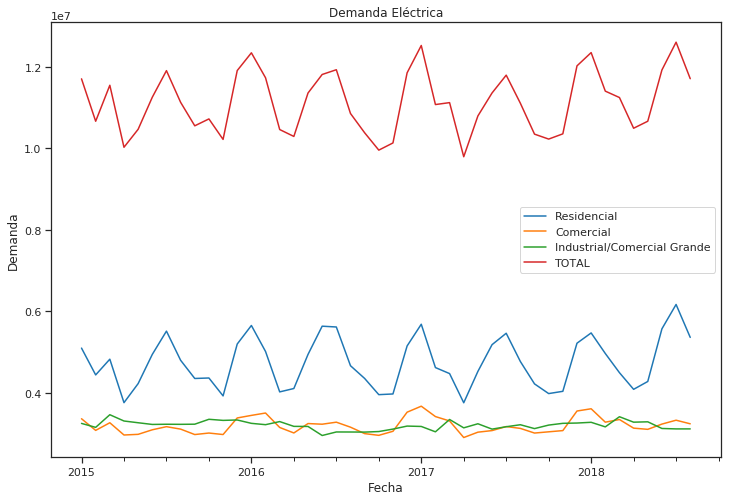

In [7]:
data.plot()
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Demanda Eléctrica')
plt.show()
plt.show()

Vamos a hacer el análisis en la serie que marca la demanda total de energía:

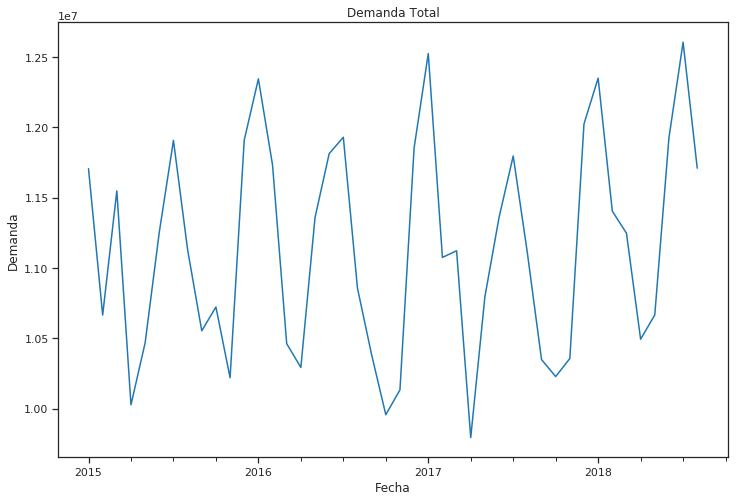

In [8]:
y = data.TOTAL
y.plot()
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Demanda Total')
plt.show()

## Descomposición de la serie de tiempo

Utilizamos el método X-13 ARIMA-SEATS para descomponer la serie de tiempo.

In [9]:
ts = y.copy()
ts.index = ts.index.to_timestamp()
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='forecasting/')

In [10]:
dir(decomposition)[-7:]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

In [11]:
pd.concat([decomposition.seasadj, decomposition.trend, decomposition.irregular], axis=1).tail()

,seasadj,trend,irregular
TIPO,,,
2018-04-01,1.140990e+07,1.135418e+07,1.004907
2018-05-01,1.092209e+07,1.142520e+07,0.955965
2018-06-01,1.142037e+07,1.148278e+07,0.994565
2018-07-01,1.161864e+07,1.150876e+07,1.009548
2018-08-01,1.163825e+07,1.149839e+07,1.012164


Pdemos ver las 3 componentes, en particular si queremos graficar la componente estacional:

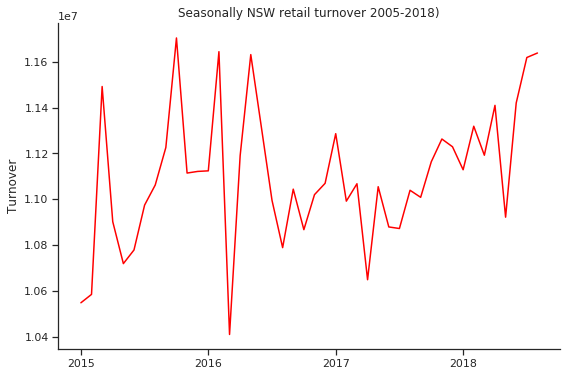

In [12]:
fig, ax= plt.subplots(figsize=(9,6))
decomposition.seasadj.plot(color='red')
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Seasonally NSW retail turnover 2005-2018)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

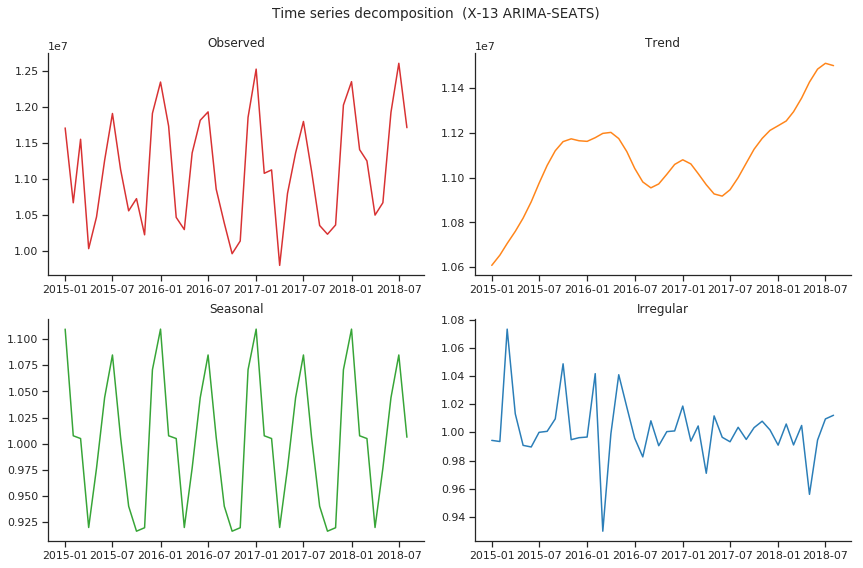

In [13]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

In [14]:
f = open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

Con el análisis realizado por x13, podemos observar que lo que mejor ajusta es el modelo multiplicativo.

## Holt-winters exponential smoothing


In [15]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [16]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()
hw_summary(ahw_sm)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               152389189756.988
 RMSE               390370.580


390370.58003516076

In [17]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               122864760983.076
 RMSE               350520.700


350520.6997925739

In [18]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='mul', damped=True, 
                                       seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               125990079015.606
 RMSE               354950.812


354950.8121072634

Podemos observar que la configuración que mejor ajusta la serie es cuando se toma un ajuste aditivo para la tendencia y multiplicativo para la componente estacional. Además observamos que en todos los casos se obtienen los mismos parametros de `alpha`, `beta` y `delta`

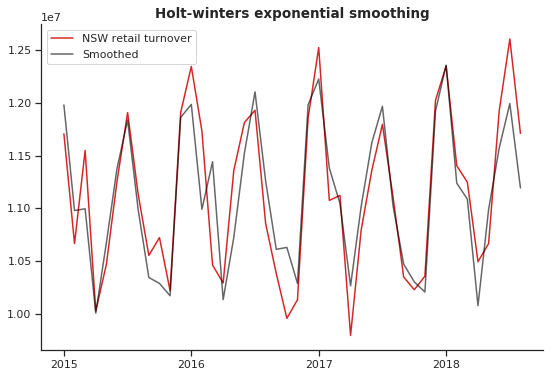

In [19]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots(figsize=(9,6))

y.plot(color='#D62728', label='NSW retail turnover')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Diagnóstico del modelo

El modelo parece capturar bastante bien las variaciones de la serie, ahora vamos a analizar los residuos.

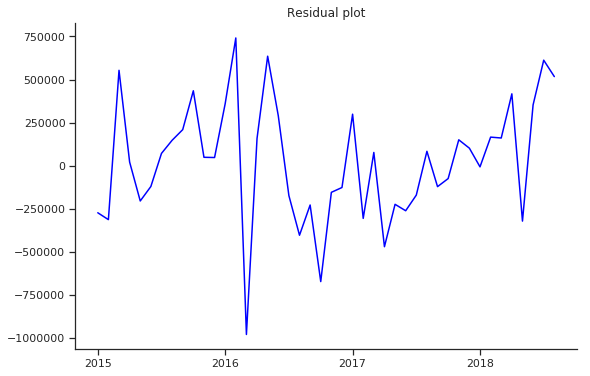

In [20]:
resid = (y-mhw_sm.fittedvalues) # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

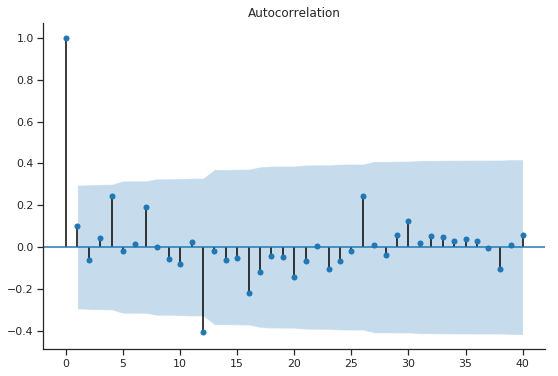

In [21]:
fig, ax = plt.subplots(figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

/home/gon/anaconda3/envs/series-temporales/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


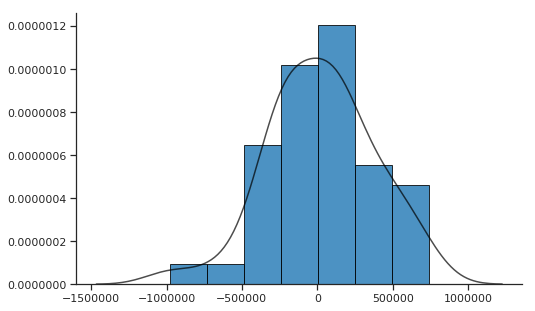

In [22]:
from plotting import histogram

histogram(resid)
plt.show()

La autocorrelación del residuo parece ser más grande que lo deseado y la media está corrida del 0, sin embargo para la poca cantidad de registros se parece bastante a una distribución normal.

## Validación del modelo

In [23]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2017-09', 'M')

In [24]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model_add = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model_add.forecast(1)[0]) # additive holt winters forecast
    
    model_mul = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model_mul.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [25]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,423432.289,93548.868
Additive,330531.304,85277.147
Multiplicative,327178.305,83264.984


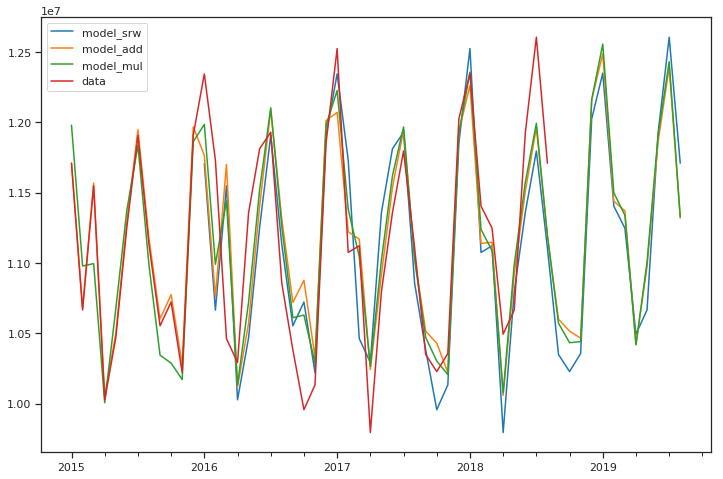

In [26]:
h=12

y2 = pd.Series(index=pd.PeriodIndex(start='2015-01', end='2019-08', freq='M'))
for i in y.index:
    y2.loc[i] = y.loc[i]
y2 = y2.shift(12)

model_add = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
model_mul = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
forecast_add = model_add.forecast(h)
forecast_mul = model_mul.forecast(h)

plot = pd.DataFrame(index=pd.PeriodIndex(start='2015-01', end='2019-08', freq='M'))
plot['model_srw'] = y2
plot['model_add'] = pd.concat([model_add.fittedvalues, forecast_add])
plot['model_mul'] = pd.concat([model_mul.fittedvalues, forecast_mul])
plot['data'] = y
#pd.Series(model.fittedvalues + model.fcastvalues), 
#                         index=pd.period_range(y.index[0],y.index[-1]+h,freq=y.index.freq))

plot.plot(figsize=(12,8))
plt.show()